In [1]:
import pandas as pd
import geopandas as gpd
import shapely

In [129]:
approved = pd.read_csv("approved power stations.csv", dtype={"Postcode": int})
lga_poas = pd.read_csv("lga_poas.csv")
#committed = pd.read_csv("./Data/committed power stations.csv", dtype={"Postcode": str})

In [103]:
#pos = gpd.read_file("POA_2021_AUST_GDA2020_SHP.zip")
#pos = pos[["POA_CODE21", "geometry"]]

#pos = pos[~pos["geometry"].isna()]

In [104]:
#pos.geometry = pos.geometry.set_precision(grid_size=0.001)

In [34]:
#approved = approved.merge(pos, left_on="Postcode", right_on="POA_CODE21", how="left")
#committed = committed.merge(pos, left_on="Postcode", right_on="POA_CODE21", how="left")

In [130]:
approved = approved.merge(lga_poas, left_on="Postcode", right_on="POA_CODE21", how="left")

In [131]:
approved = approved.groupby("LGA_CODE24").agg({"Installed capacity (MW)": "sum"}).reset_index()

In [132]:
approved["capacity"] = approved["Installed capacity (MW)"]

In [112]:
import math

In [133]:
approved["logCap"] = approved["capacity"].apply(lambda x: math.log(x*100, 10))

<Axes: ylabel='Frequency'>

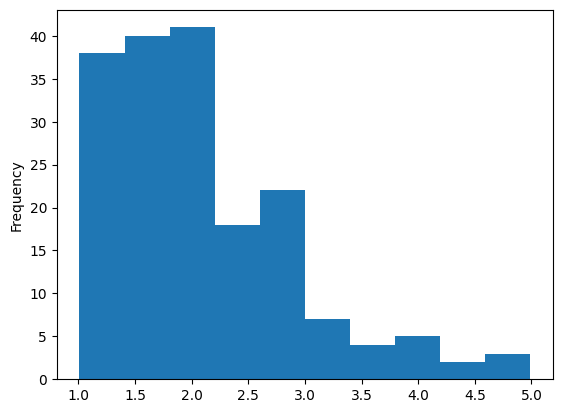

In [134]:
approved.logCap.plot.hist(bins=10)

In [135]:
local_govs = gpd.read_file("LGA_2024_AUST_GDA2020.zip")

In [136]:
local_govs = local_govs[["LGA_CODE24", "LGA_NAME24", "STE_NAME21", "geometry"]]
local_govs = local_govs[~local_govs["geometry"].isna()]

local_govs["LGA_CODE24"] = local_govs["LGA_CODE24"].astype(int)

In [137]:
local_govs.geometry = local_govs.geometry.set_precision(grid_size=0.001)

In [138]:
approved = approved.merge(local_govs, left_on="LGA_CODE24", right_on="LGA_CODE24", how="left")

In [139]:
approved = gpd.GeoDataFrame(approved, geometry="geometry")

In [140]:
approved.to_csv("approved_sum.csv", index=False)

In [141]:
approved = approved.to_json(show_bbox=True, to_wgs84=True)

import json

with open("approved_sum.json", "w") as f:
    f.write(approved)

In [16]:
local_govs.to_csv("local_govs.csv", index=False)

In [17]:
local_govs = local_govs.to_json(show_bbox=True, to_wgs84=True)

with open("local_govs.json", "w") as f:
    f.write(local_govs)

LGA - POA 

In [84]:
lgas = gpd.read_file("LGA_2024_AUST_GDA2020.zip")
poas = gpd.read_file("POA_2021_AUST_GDA2020_SHP.zip")

In [85]:
lgas = lgas[~lgas["geometry"].isna()]
poas = poas[~poas["geometry"].isna()]

In [71]:
poas["area"] = poas["geometry"].to_crs("EPSG:7843").area
poas["lgas"] = poas["geometry"].apply(lambda x: lgas[lgas["geometry"].overlaps(x)]["LGA_CODE24"].values)

/tmp/ipykernel_15823/2378352242.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  poas["area"] = poas["geometry"].to_crs("EPSG:7843").area
/home/spulick/miniforge3/envs/web/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [86]:
intersects = gpd.overlay(poas, lgas, how="intersection")

/tmp/ipykernel_15823/3703981172.py:1: UserWarning: `keep_geom_type=True` in overlay resulted in 303 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersects = gpd.overlay(poas, lgas, how="intersection")


In [91]:
intersects["new_area"] = intersects["geometry"].to_crs("EPSG:7843").area

/tmp/ipykernel_15823/2899470481.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersects["new_area"] = intersects["geometry"].to_crs("EPSG:7843").area


In [92]:
intersects.sort_values(by = "new_area", inplace=True)

In [93]:
intersects.drop_duplicates(subset="POA_CODE21", keep="first", inplace=True)

In [96]:
intersects.sort_values(by = "POA_CODE21", inplace=True)

In [98]:
lga_poas = intersects[["POA_CODE21", "LGA_CODE24"]]

In [100]:
lga_poas.to_csv("lga_poas.csv", index=False)